PROJECT PLANNING

Brainstorming and initial thoughts:

After a brief google search, I could find only size of home identified as a key driver of property value, within the three target estimators. So, I find it likely that square feet of home will have the most explanatory value. The number of bedrooms and bathrooms in a house seems likely to increase with the size of a property. Because of this, I find it unlikely that these numbers will provide additional explanatory value.

ACQUIRE

I Used SQL inquiry to acquire data from Zillow database on target features and tax value.

The taxvaluedollarcnt column was used to represent, Tax Value, and aliased as Tax_Value

The lotsizesquarefeet column was used represent, size in square feet, and aliased as Size 

The bedroomcnt column was used represent, number of bedrooms and aliased as Bedrooms 

The bathroomcnt column was used to represent, number of bathrooms and aliased  as "Bathrooms"
          
I limited the query to housing types listed as Residential General, Single Family Residential, Rural Residence, Mobile Home, Bungalow, Manufactured, Modular, Prefabricated Homes, Patio Home, or Inferred Single Family Residential to target ‘single unit’ properties.

I also limited query to units who's last transaction date was between 2017-05-01 and 2017-06-30 to target units bought during the ‘hot months’ of May and June 2017

I only accepted rows that did not have null values in any of the above columns

In [1]:
import acquire as a
df = a.wrangle_zillow()

In [2]:
df.head()

,Tax_Value,Size,Bedrooms,Bathrooms
0,498347.0,6211.0,4.0,2.0
1,549917.0,9109.0,3.0,3.0
2,235272.0,7538.0,3.0,2.0
3,340000.0,111564.0,2.0,2.0
4,2017254.0,10497.0,2.0,3.0


In [3]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16026 entries, 0 to 16025
Data columns (total 4 columns):
Tax_Value    16026 non-null float64
Size         16026 non-null float64
Bedrooms     16026 non-null float64
Bathrooms    16026 non-null float64
dtypes: float64(4)
memory usage: 500.9 KB


Tax_Value    0
Size         0
Bedrooms     0
Bathrooms    0
dtype: int64

PREP

Data contains no null values and is of the desired type. No further preparation is needed, outside of the initial SQL inquiry.

SPLIT AND SCALE

In [4]:
# Split Dataframe into x and y
x = df.drop(columns='Tax_Value')
y = df[['Tax_Value']]

In [5]:
# Split x and y data into test and train set for each
import split_scale as ss
train_pct = .8
x_train, x_test, y_train, y_test = ss.split_my_data(x, y, train_pct)

In [6]:
# Scale x_train and x_test using standard scaler
train = x_train
test = x_test

x_train, x_test, scaler = ss.standard_scaler(train,test)

DATA EXPLORATION

I will begin my exploration by using a Pearson’s r test to examine the strength of the correlation between tax value and each of the target variables.

In [7]:
import data_exploration as de

#Bathrooms and Tax_Value
var_1 = x_train.Bathrooms
var_2 = y_train.Tax_Value

de.get_pearsons_r(var_1,var_2)

Pearson's r Results:
(0.51027887975273, 0.0)


In [8]:
#Bedrooms and Tax_Value
var_1 = x_train.Bedrooms
var_2 = y_train.Tax_Value

de.get_pearsons_r(var_1,var_2)

Pearson's r Results:
(0.25365657618533505, 2.1578396798003654e-187)


In [9]:
#Size and Tax_Value
var_1 = x_train.Size
var_2 = y_train.Tax_Value

de.get_pearsons_r(var_1,var_2)

Pearson's r Results:
(0.049808832355318536, 1.675213873880396e-08)


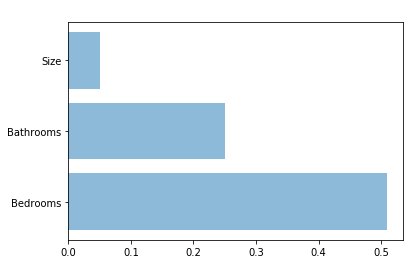

In [12]:
import numpy as np
import matplotlib.pyplot as plt

objects = ('Bedrooms','Bathrooms','Size')
y_pos = np.arange(len(objects))
performance = [.51,.25,.05]

plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Amount Correlated',color='white')
plt.title('Correlation with Tax_Value', color='white')

plt.show()

Each Pearson’s r test showed a high level of significance and the following correlation strengths when compared to tax value

Bathrooms: .51

Bedrooms: .25

Size: .05

Because of its low correlation Size is not likely to provide significant explanatory value.

Bedrooms and Bathrooms each have a much higher correlation. 

I will now perform a Pearson's r test to determine if Bedrooms and Bathrooms are correlated. If they are not, we may gain a significant amount of explanatory value from combining both variables.

In [13]:
var_1 = x_train.Bedrooms
var_2 = x_train.Bathrooms

de.get_pearsons_r(var_1,var_2)

Pearson's r Results:
(0.6694723725941977, 0.0)


Bedrooms and Bathrooms are highly correlated (.67). Therefore, using more than one of these variables as predicters would not result in significant additional explanatory value. Therefore, we should proceed using only the variable that is most highly correlated with tax value. That variable is Bathrooms.

FEATURE SELECTION

Feature selection has been largely placed on hold unless time permits for reviewing features outside of the three target features, per educator instruction

Based on my previous tests, of the target features I have considered I would use only the Bathrooms feature.

I will now create a the data frame to be used for the model. It will contain the train group of the bedroom feature, scaled using a standard scaler and the train group of Tax_value unscaled.

In [14]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

model_df = x_train[['Bathrooms']] 
model_df[['Tax_Value']] = y_train[['Tax_Value']]

In [15]:
model_df.head()

,Bathrooms,Tax_Value
4576,-1.152705,269641.0
11842,-0.190930,134865.0
10111,-0.190930,465469.0
5189,-0.190930,446551.0
15819,-0.190930,97502.0


MODELING AND EVALUATION

First I will generate the baseline error amounts.

In [16]:
import model as m
df = model_df
column = "Tax_Value"
SSE_base, MSE_base, RMSE_base, n_base = m.baseline_mean_errors(df,column)

I will now fit the model data frame into a regression model and generate a data frame with predictions for Tax_Value based on the Bedrooms feature. It will have the column name yhat.

In [17]:
df = model_df
x_col = ['Bathrooms']
y_col = 'Tax_Value'

Bathrooms_yhat = m.get_yhat(df,x_col,y_col)

I will now use the predictions produced by the regression model to generate the error amounts for the modle.

In [18]:
yhat = Bathrooms_yhat[['yhat']]
y = model_df[['Tax_Value']]

Bathrooms_SSE, Bathrooms_MSE, Bathrooms_RMSE, Bathrooms_R2 = m.regression_errors(y, yhat)

In [19]:
Bathrooms_RMSE

570367.7764974856

In [20]:
RMSE_base

663211.4109961692

In [21]:
Bathrooms_SSE

4170594713982911.0

In [22]:
SSE_base

5638868996160291.0

In [23]:
Bathrooms_MSE

325319400466.6857

In [24]:
MSE_base

439849375675.5297

After comparing the error amounts of the model to the error amounts of the baseline and seeing that the error amounts for the model are lower we can conclude that the model does perform better than the baseline. Next we will have a look at the r'squared value.

In [25]:
Bathrooms_R2

0.26038453512169557

26% of variance in Tax_Value is explained by the feature Bathrooms. 

In conclusion, of the three target features, size in square feet, number of bedrooms, and number of bathrooms, number of bathrooms alone had most explanatory value. 26% of the variance in the assigned tax value can be explained by the number of Bathrooms it has. 

I Used the fips values to identify county and state of each property and graphed a tax rate distribution for the properties in each county.  

In [26]:
import histographs as h
df = h.wrangle_zillow_graphs()

[]

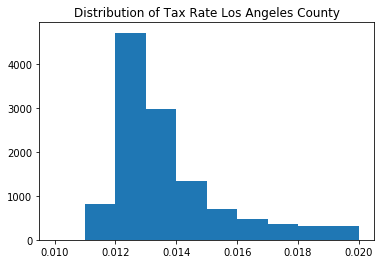

In [27]:

plt.title('Distribution of Tax Rate Los Angeles County')
plt.hist(df.Tax_Rate,bins=[.010,.011,.012,.013,.014,.015,.016,.017,.018,.019,.02])
plt.plot()

In [28]:
df = h.wrangle_zillow_graphs2()

[]

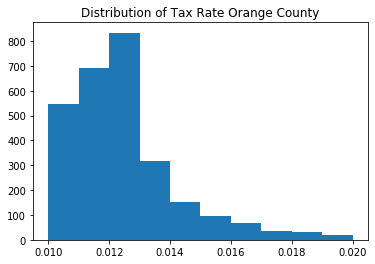

In [29]:
plt.title('Distribution of Tax Rate Orange County')
plt.hist(df.Tax_Rate,bins=[.010,.011,.012,.013,.014,.015,.016,.017,.018,.019,.02])
plt.plot()

In [30]:
df = h.wrangle_zillow_graphs3()

[]

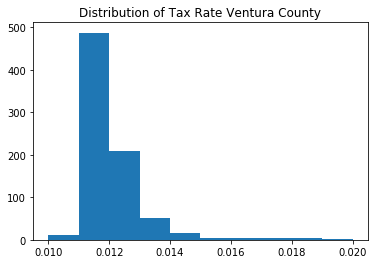

In [31]:
plt.title('Distribution of Tax Rate Ventura County')
plt.hist(df.Tax_Rate,bins=[.010,.011,.012,.013,.014,.015,.016,.017,.018,.019,.02])
plt.plot()